3중 SMA 교차 전략 사용

In [1]:
import pandas as pd

In [3]:
data = pd.read_csv("bitcoin.csv", parse_dates=["Date"], index_col="Date")
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    36168 non-null  float64
 1   High    36168 non-null  float64
 2   Low     36168 non-null  float64
 3   Close   36168 non-null  float64
 4   Volume  36168 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

In [10]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.

    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade


    Methods
    =======
    get_data:
        imports the data.

    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).

    prepare_data:
        prepares the data for backtesting.

    run_backtest:
        runs the strategy backtest.

    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.

    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).

    find_best_strategy:
        finds the optimal strategy (global maximum).


    print_performance:
        calculates and prints various performance metrics.

    '''

    def __init__(self, filepath, symbol, start, end, tc):

        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))

    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)

    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw

    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).

        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.

        '''

        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]


        self.prepare_data(smas = smas)
        self.run_backtest()

        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data

        self.print_performance()

    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################

        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()

        data.dropna(inplace = True)

        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)

        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################

        self.results = data

    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''

        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc

        self.results = data

    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).

        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).

        SMA_M_range: tuple
            tuples of the form (start, end, step size).

        SMA_L_range: tuple
            tuples of the form (start, end, step size).

        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''

        self.metric = metric

        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe

        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)

        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))

        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))

        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()


    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''

        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))

    ############################## Performance ######################################

    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''

        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)

        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))

        print(100 * "=")

    def calculate_multiple(self, series):
        return np.exp(series.sum())

    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1

    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year

    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)

    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [16]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
tc = -0.00085 # average/approx Trading Costs in Spot Market
# tc = -0.00050 # average/approx Trading Costs in Futures Market
sma_s = 15
sma_m = 50
sma_l = 200

In [17]:
tester = Long_Short_Backtester(filepath, symbol, start, end, tc)

In [18]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [19]:
tester.test_strategy(smas=(sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         14.96014
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       2.444755


CAGR:                        0.92986
Annualized Mean:             0.657168
Annualized Std:              0.733852
Sharpe Ratio:                1.267095


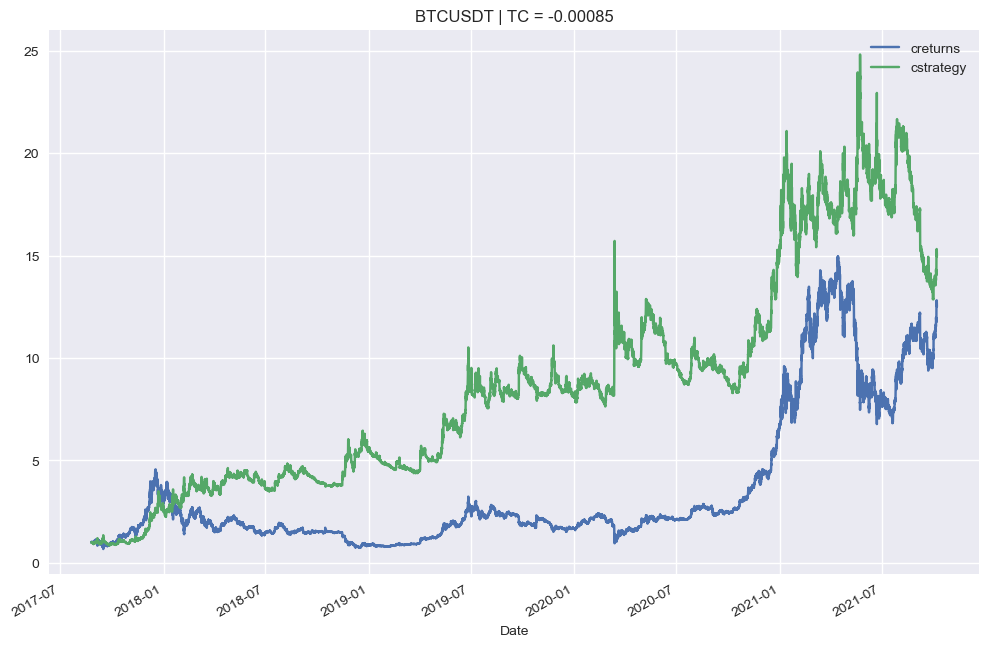

In [20]:
tester.plot_results()

In [21]:
tester.results

,Close,returns,SMA_S,SMA_M,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,
2017-08-25 11:00:00,4361.27,0.010821,4319.996000,4214.2724,4132.71175,1,NaN,0.0,1.010880,NaN
2017-08-25 12:00:00,4309.69,-0.011897,4326.842000,4215.9058,4132.71605,1,-0.011897,0.0,0.998925,0.988173
2017-08-25 13:00:00,4312.00,0.000536,4325.893333,4217.3860,4132.69945,1,0.000536,0.0,0.999460,0.988703
2017-08-25 14:00:00,4305.00,-0.001625,4325.159333,4219.1724,4132.60270,1,-0.001625,0.0,0.997837,0.987098
2017-08-25 15:00:00,4394.36,0.020545,4327.050000,4222.8396,4132.82455,1,0.020545,0.0,1.018550,1.007587
...,...,...,...,...,...,...,...,...,...,...
2021-10-07 05:00:00,54735.76,-0.006146,54917.700667,52111.0732,47458.34450,1,-0.006146,0.0,12.686966,15.165239
2021-10-07 06:00:00,54534.16,-0.003690,54887.698667,52218.3902,47522.16155,1,-0.003690,0.0,12.640238,15.109383
2021-10-07 07:00:00,54755.92,0.004058,54878.672000,52327.0086,47586.68185,1,0.004058,0.0,12.691639,15.170824


In [22]:
tester.results.trades.value_counts()

0.0    34888
1.0     1080
2.0        1
Name: trades, dtype: int64

## 현실적인 관점에서의 레버리지를 이용한 수익

In [23]:
import pandas as pd
import numpy as np

In [25]:
df = pd.DataFrame(data={"Price": [1, 1.1, 1.25, 1.3], "Units": [100, 100, 100, 100]}, index=[0, 1, 2, 3])
df

,Price,Units
0,1.00,100
1,1.10,100
2,1.25,100
3,1.30,100


In [26]:
df["Trade_Value"] = df.Price * df.Units
df

,Price,Units,Trade_Value
0,1.00,100,100.0
1,1.10,100,110.0
2,1.25,100,125.0
3,1.30,100,130.0


In [27]:
df["Returns"] = df.Trade_Value.pct_change()
df

,Price,Units,Trade_Value,Returns
0,1.00,100,100.0,NaN
1,1.10,100,110.0,0.100000
2,1.25,100,125.0,0.136364
3,1.30,100,130.0,0.040000


In [28]:
df["Compound"] = df.Returns.add(1).cumprod() - 1
df

,Price,Units,Trade_Value,Returns,Compound
0,1.00,100,100.0,NaN,NaN
1,1.10,100,110.0,0.100000,0.10
2,1.25,100,125.0,0.136364,0.25
3,1.30,100,130.0,0.040000,0.30


새로운 가정 : 레버리지를 2로, 50(초기 거래 비용의 50퍼센트)의 증거금을 지불

In [29]:
leverage = 2
leverage

2

In [30]:
df["Margin"] = df.Trade_Value[0] / leverage
df

,Price,Units,Trade_Value,Returns,Compound,Margin
0,1.00,100,100.0,NaN,NaN,50.0
1,1.10,100,110.0,0.100000,0.10,50.0
2,1.25,100,125.0,0.136364,0.25,50.0
3,1.30,100,130.0,0.040000,0.30,50.0


In [31]:
df["PL_unreal"] = df.Trade_Value - df.Trade_Value[0]
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal
0,1.00,100,100.0,NaN,NaN,50.0,0.0
1,1.10,100,110.0,0.100000,0.10,50.0,10.0
2,1.25,100,125.0,0.136364,0.25,50.0,25.0
3,1.30,100,130.0,0.040000,0.30,50.0,30.0


In [32]:
df["Equity"] = df.Margin + df.PL_unreal
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0


In [33]:
df["Equity_Returns"] = df.Equity.pct_change()
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity,Equity_Returns
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0,NaN
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0,0.200000
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0,0.250000
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0,0.066667


In [34]:
df.Returns * leverage

0         NaN
1    0.200000
2    0.272727
3    0.080000
Name: Returns, dtype: float64

In [35]:
df["EL"] = df.Trade_Value / df.Equity
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity,Equity_Returns,EL
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0,NaN,2.000000
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0,0.200000,1.833333
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0,0.250000,1.666667
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0,0.066667,1.625000


In [36]:
df.Returns * df.EL.shift()

0         NaN
1    0.200000
2    0.250000
3    0.066667
dtype: float64

In [38]:
df["EL2"] = leverage * (1 + df.Compound) / (1 + df.Compound * leverage)
df["EL2"].fillna(leverage, inplace=True)
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity,Equity_Returns,EL,EL2
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0,NaN,2.000000,2.000000
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0,0.200000,1.833333,1.833333
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0,0.250000,1.666667,1.666667
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0,0.066667,1.625000,1.625000


In [39]:
levered_returns = df.Returns * df.EL2.shift()
levered_returns

0         NaN
1    0.200000
2    0.250000
3    0.066667
dtype: float64

In [40]:
levered_returns = pd.Series(np.where(levered_returns < -1, -1, levered_returns))
levered_returns

0         NaN
1    0.200000
2    0.250000
3    0.066667
dtype: float64

In [41]:
levered_returns.add(1).cumprod()

0    NaN
1    1.2
2    1.5
3    1.6
dtype: float64

## 선물 백테스팅 클래스

In [42]:
class Futures_Backtester():
    ''' Class for the vectorized backtesting of (levered) Futures trading strategies.

    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade


    Methods
    =======
    get_data:
        imports the data.

    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).

    prepare_data:
        prepares the data for backtesting.

    run_backtest:
        runs the strategy backtest.

    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.

    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).

    find_best_strategy:
        finds the optimal strategy (global maximum).

    add_sessions:
        adds/labels trading sessions and their compound returns.

    add_leverage:
        adds leverage to the strategy.

    print_performance:
        calculates and prints various performance metrics.

    '''

    def __init__(self, filepath, symbol, start, end, tc):

        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))

    def __repr__(self):
        return "Futures_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)

    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw

    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).

        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.

        '''

        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]


        self.prepare_data(smas = smas)
        self.run_backtest()

        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data

        self.print_performance()

    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################

        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()

        data.dropna(inplace = True)

        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)

        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################

        self.results = data

    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''

        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc

        self.results = data

    def plot_results(self, leverage = False): #Adj!
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        elif leverage: # NEW!
            title = "{} | TC = {} | Leverage = {}".format(self.symbol, self.tc, self.leverage)
            self.results[["creturns", "cstrategy", "cstrategy_levered"]].plot(title=title, figsize=(12, 8))
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).

        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).

        SMA_M_range: tuple
            tuples of the form (start, end, step size).

        SMA_L_range: tuple
            tuples of the form (start, end, step size).

        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''

        self.metric = metric

        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe

        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)

        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))

        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))

        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()


    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''

        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))


    def add_sessions(self, visualize = False): # NEW!!!
        '''
        Adds/Labels Trading Sessions and their compound returns.

        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''

        if self.results is None:
            print("Run test_strategy() first.")

        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()

    def add_leverage(self, leverage, report = True): # NEW!!!
        '''
        Adds Leverage to the Strategy.

        Parameter
        ============
        leverage: float (positive)
            degree of leverage.

        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        self.add_sessions()
        self.leverage = leverage

        data = self.results.copy()
        data["simple_ret"] = np.exp(data.strategy) - 1
        data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
        data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["strategy_levered"] = levered_returns
        data["cstrategy_levered"] = data.strategy_levered.add(1).cumprod()

        self.results = data

        if report:
            self.print_performance(leverage = True)

    ############################## Performance ######################################

    def print_performance(self, leverage = False): # Adj
        ''' Calculates and prints various Performance Metrics.
        '''

        data = self.results.copy()

        if leverage: # NEW!
            to_analyze = np.log(data.strategy_levered.add(1))
        else:
            to_analyze = data.strategy


        strategy_multiple = round(self.calculate_multiple(to_analyze), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(to_analyze), 6)
        ann_mean =          round(self.calculate_annualized_mean(to_analyze), 6)
        ann_std =           round(self.calculate_annualized_std(to_analyze), 6)
        sharpe =            round(self.calculate_sharpe(to_analyze), 6)

        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))

        print(100 * "=")

    def calculate_multiple(self, series):
        return np.exp(series.sum())

    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1

    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year

    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)

    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [106]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2020-08-17"
end = "2021-10-07"
# tc = -0.00085 # average/approx Trading Costs in Spot Market
tc = -0.00050 # average/approx Trading Costs in Futures Market
sma_s = 15
sma_m = 50
sma_l = 200

In [107]:
tester = Futures_Backtester(filepath, symbol, start, end, tc)
tester

Futures_Backtester(symbol = BTCUSDT, start = 2020-08-17, end = 2021-10-07)

In [108]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2020-08-17 00:00:00,11910.99,11933.15,11801.00,11845.31,2488.440228,NaN
2020-08-17 01:00:00,11845.31,11849.60,11781.25,11843.63,1307.139321,-0.000142
2020-08-17 02:00:00,11843.68,11868.00,11769.78,11860.27,1539.784049,0.001404
2020-08-17 03:00:00,11860.26,11872.82,11837.48,11844.71,1295.923737,-0.001313
2020-08-17 04:00:00,11844.72,11858.91,11802.35,11809.38,1454.171816,-0.002987
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [109]:
tester.test_strategy(smas=(sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.709802
Multiple (Buy-and-Hold):     4.649738
--------------------------------------
Out-/Underperformance:       -2.939936


CAGR:                        0.616359
Annualized Mean:             0.480577
Annualized Std:              0.663805
Sharpe Ratio:                0.928524


In [111]:
tester.add_leverage(leverage=2)

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.038104
Multiple (Buy-and-Hold):     4.649738
--------------------------------------
Out-/Underperformance:       -2.611634


CAGR:                        0.891584
Annualized Mean:             0.637946
Annualized Std:              1.261802
Sharpe Ratio:                0.706596


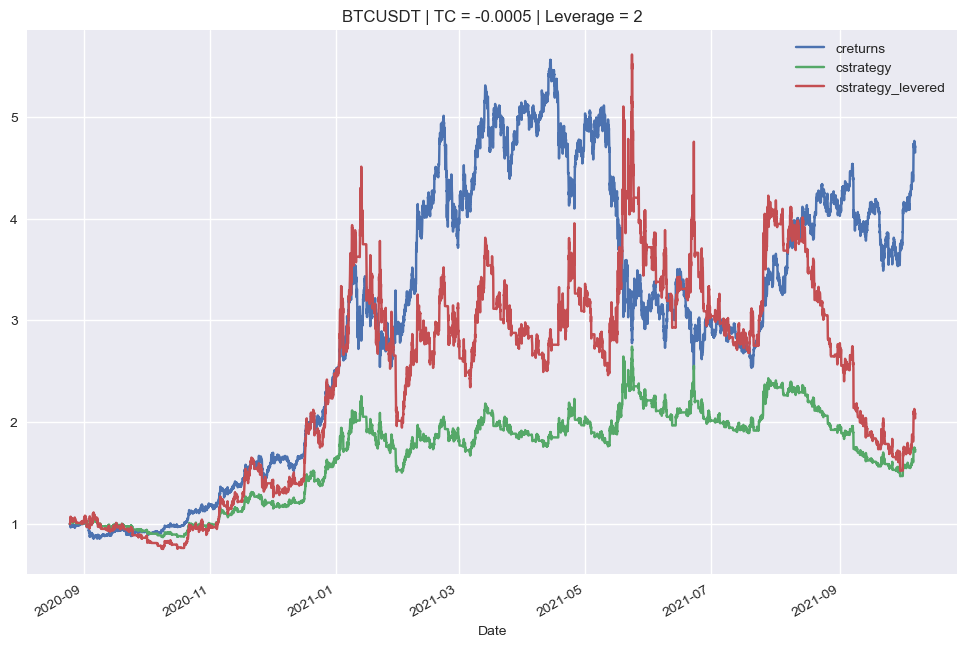

In [112]:
tester.plot_results(leverage=True)

In [100]:
tester.results

,Close,returns,SMA_S,SMA_M,SMA_L,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret,eff_lev,strategy_levered,cstrategy_levered
Date,,,,,,,,,,,,,,,,
2018-08-25 07:00:00,6672.01,-0.000447,6681.345333,6540.3820,6474.16065,1,NaN,0.0,0.999554,NaN,0.0,NaN,NaN,3.000000,NaN,NaN
2018-08-25 08:00:00,6707.99,0.005378,6689.614667,6545.8616,6475.96095,1,0.005378,0.0,1.004944,1.005393,0.0,0.005393,0.005393,2.968159,0.016178,1.016178
2018-08-25 09:00:00,6688.65,-0.002887,6693.369333,6550.8748,6477.70425,1,-0.002887,0.0,1.002046,1.002494,0.0,0.002494,-0.002883,2.985147,-0.008558,1.007482
2018-08-25 10:00:00,6712.99,0.003632,6699.331333,6556.5266,6479.20905,1,0.003632,0.0,1.005693,1.006142,0.0,0.006142,0.003639,2.963814,0.010863,1.018426
2018-08-25 11:00:00,6703.46,-0.001421,6705.228000,6562.4356,6480.65715,1,-0.001421,0.0,1.004265,1.004714,0.0,0.004714,-0.001420,2.972112,-0.004208,1.014141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07 19:00:00,8211.00,-0.002558,8056.077333,7990.7802,8128.22435,0,-0.000000,0.0,1.230114,2.368138,289.0,0.000000,0.000000,3.000000,0.000000,4.890237
2019-10-07 20:00:00,8197.82,-0.001606,8080.152000,7993.5366,8129.23365,0,-0.000000,0.0,1.228140,2.368138,289.0,0.000000,0.000000,3.000000,0.000000,4.890237
2019-10-07 21:00:00,8191.87,-0.000726,8104.628000,7996.0468,8130.21465,0,-0.000000,0.0,1.227248,2.368138,289.0,0.000000,0.000000,3.000000,0.000000,4.890237


In [101]:
tester.results.trades.value_counts()

0.0    9486
1.0     289
Name: trades, dtype: int64

In [92]:
tester.results.eff_lev.describe()

count    9747.000000
mean        2.876868
std         0.233925
min         1.808469
25%         2.784267
50%         3.000000
75%         3.000000
max         3.816043
Name: eff_lev, dtype: float64

In [121]:
tester.add_leverage(leverage=8)

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.0
Multiple (Buy-and-Hold):     4.649738
--------------------------------------
Out-/Underperformance:       -4.649738


CAGR:                        -1.0
Annualized Mean:             -inf
Annualized Std:              nan
Sharpe Ratio:                nan


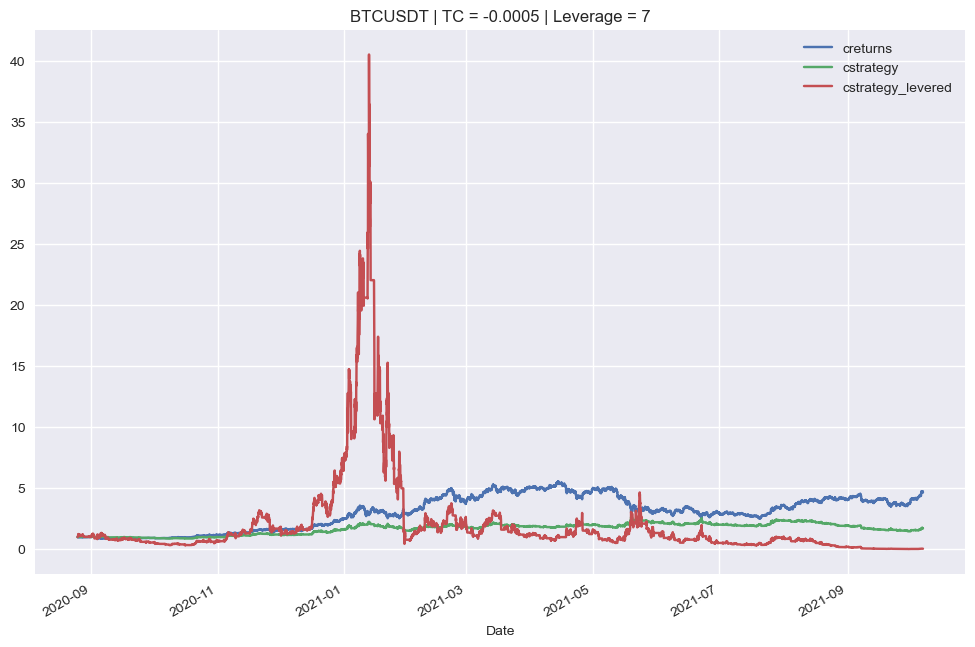

In [120]:
tester.plot_results(leverage=True)